1. load the data and separate in X all the columns but the last one, in y the last column,
then produce a pairplot of X and decide which pair of columns is most interesting for a 2d
scatterplot, ad produce the scatterplot (5pt)
2. find the best clustering scheme for X with a method of your choice, plot ssd and global sil-
houhette index for an appropriate range of parameters and show the chosen hyperparameter(s)
(5pt)
3. consider carefully the number of clusters, simple optimisation of the silhouette will not be
enough, consider also the elbow plot and decide visually the best number of clusters
4. fit the clustering scheme to y_km, then produce the confusion matrix comparing y and y_km
with sklearn.metrics.confusion_matrix, the resulting confusion matrix must be “sorted” using
the function max_diag provided below, producing the final confusion matrix cm_km (5pt)
5. in a comment explain why function max_diag is useful (2pt)
6. compute the accuracy a_km of y_km versus y as the ratio the sum of the main diagonal of
cm_km and the number of samples in X (2pt)
7. rescale X using sklearn.preprocessing.MinMaxScaler, producing the scaled dataset X_mms
(3pt)
8. repeat point 3 and 5 above, fitting X_mms to y_km_mms and producing the confusion
matrix cm_km_mms reordered with max_diag and the accuracy a_km_mms as above (3pt)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

random_state = 42
np.random.seed(random_state)
filename = './datasets/seeds_dataset.txt'
separator = '\t'

# 1

In [4]:
df = np.loadtxt(filename, delimiter=separator)
df = pd.DataFrame(df)

In [5]:
df.head()

,0,1,2,3,4,5,6,7
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0.0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0.0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0.0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0.0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0.0


In [6]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

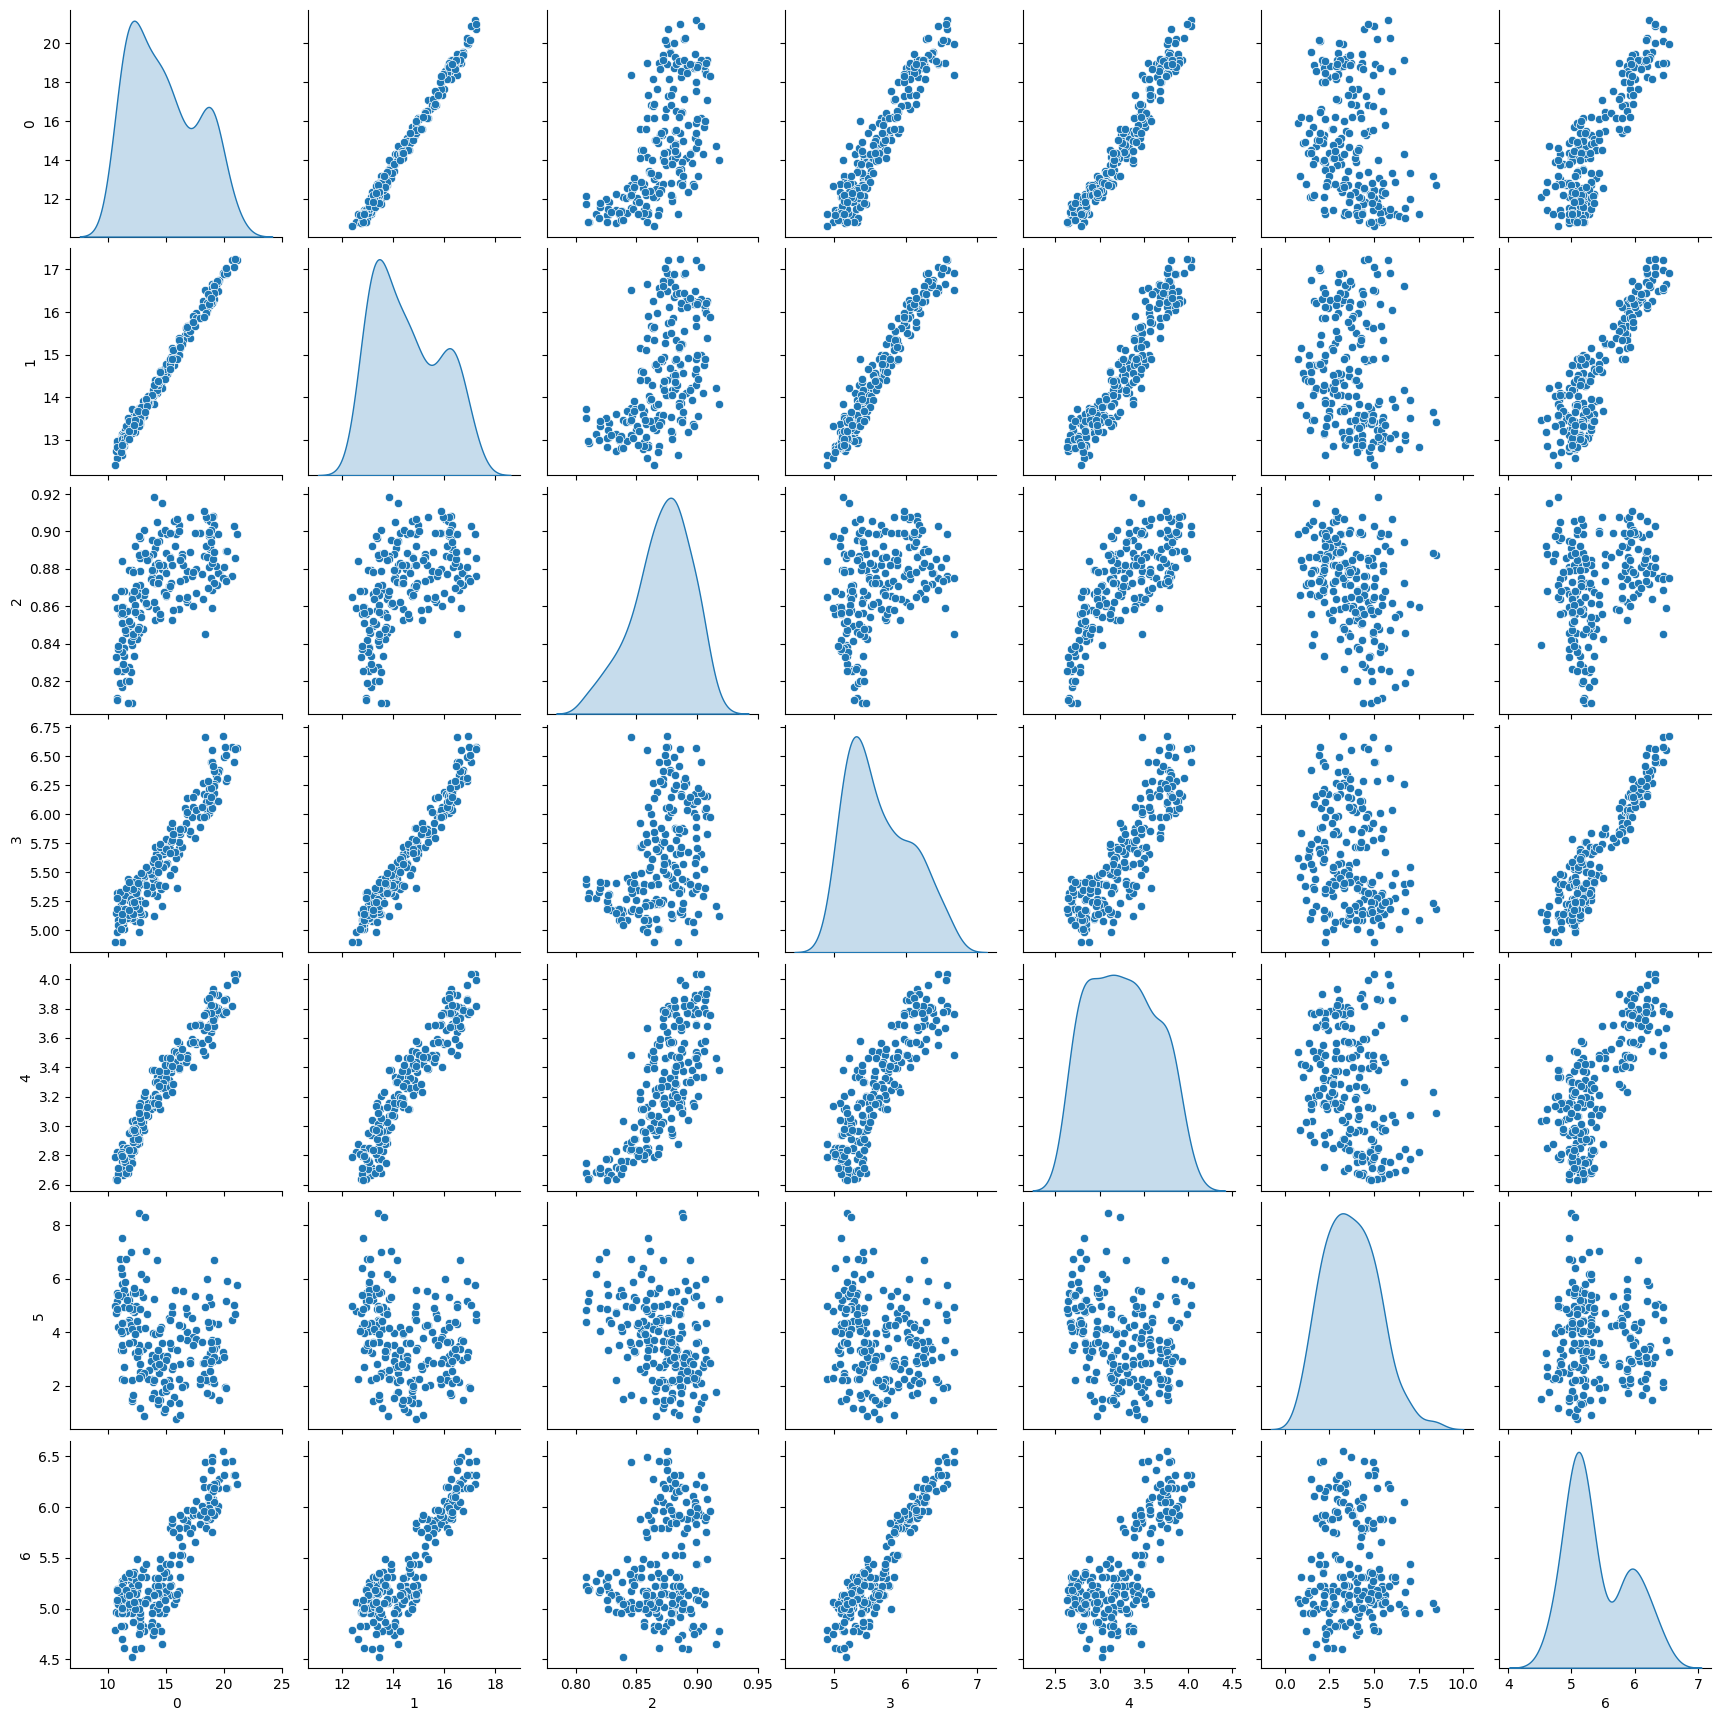

In [7]:
sns.pairplot(X, diag_kind='kde');

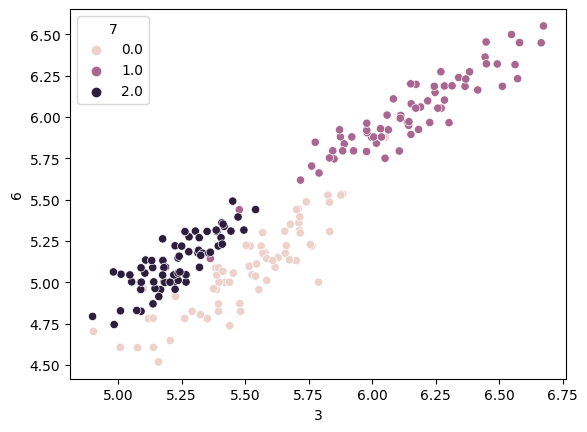

In [10]:
focus = [3, 6]
sns.scatterplot(x = focus[0], y = focus[1], data = X, hue = y);

# 2

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

max_clusters = 10
silhouettes = []
inertias = []
for n_clusters in range(2, max_clusters + 1):
    model = KMeans(n_clusters = n_clusters, random_state = random_state)
    pred = model.fit_predict(X)
    silhouettes.append(silhouette_score(X, pred))
    inertias.append(model.inertia_)

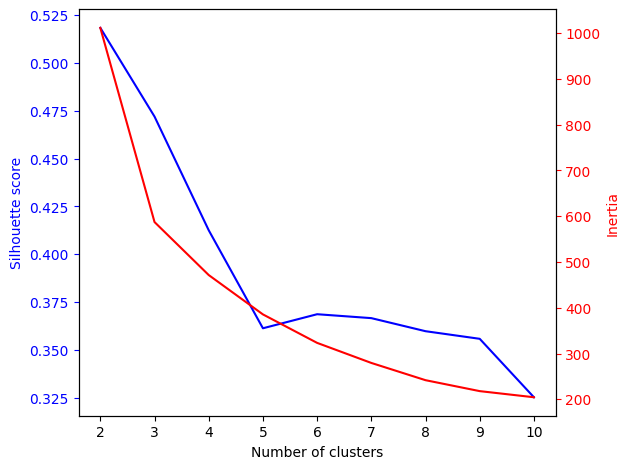

In [12]:
fig, ax1 = plt.subplots()
ax1.plot(range(2, max_clusters + 1), silhouettes, 'b-')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Silhouette score', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(range(2, max_clusters + 1), inertias, 'r-')
ax2.set_ylabel('Inertia', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

# 3

In [13]:
best_k = 3
model = KMeans(n_clusters = best_k, random_state = random_state)
y_km = model.fit_predict(X)

In [14]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def plot_clusters(X, y, dim, points,
                  labels_prefix = 'cluster', 
                  points_name = 'centroids',
                  colors = cm.tab10, # a qualitative map 
                      # https://matplotlib.org/examples/color/colormaps_reference.html
#                   colors = ['brown', 'orange', 'olive', 
#                             'green', 'cyan', 'blue', 
#                             'purple', 'pink'],
#                   points_color = 'red'
                  points_color = cm.tab10(10) # by default the last of the map (to be improved)
                 ):
    """
    Plot a two dimensional projection of an array of labelled points
    X:      array with at least two columns
    y:      vector of labels, length as number of rows in X
    dim:    the two columns to project, inside range of X columns, e.g. (0,1)
    points: additional points to plot as 'stars'
    labels_prefix: prefix to the labels for the legend ['cluster']
    points_name:   legend name for the additional points ['centroids']
    colors: a color map
    points_color: the color for the points
    """
    # plot the labelled (colored) dataset and the points
    labels = np.unique(y)
    for i in range(len(labels)):
        color = colors(i / len(labels)) # choose a color from the map
        plt.scatter(X[y==labels[i],dim[0]], 
                    X[y==labels[i],dim[1]], 
                    s=10, 
                    c = [color], # scatter requires a sequence of colors
                    marker='s', 
                    label=labels_prefix+str(labels[i]))
    plt.scatter(points[:,dim[0]], 
                points[:,dim[1]], 
                s=50, 
                marker='*', 
                c=[points_color], 
                label=points_name)
    plt.legend()
    plt.grid()
    plt.show()

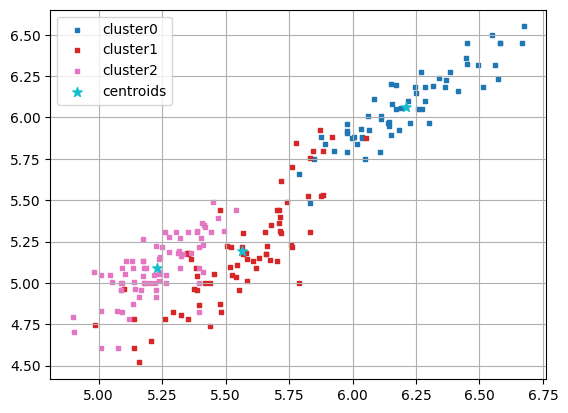

In [16]:
plot_clusters(X.values, y_km, (focus[0], focus[1]), model.cluster_centers_)

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_km)

array([[ 1, 60,  9],
       [60, 10,  0],
       [ 0,  2, 68]])

In [18]:
def max_diag(sq_arr):
    """
    Given a square matrix produces another squared matrix with the same contents, 
    but the columns are re-orered in order to have the highest values in the main diagonal
    Parameter: sq_arr - a squared matrix
    Example:
    In [1]: import numpy as np
            max_diag(np.array([[1,10],[20,2]]))
    Out[1]: array([[10.,  1.],
                   [ 2., 20.]])
    This function is useful to reorder a confusion matrix when the two label vectors
    have different codings
    """
    import numpy as np
    if len(sq_arr.shape) != 2 or sq_arr.shape[0]!=sq_arr.shape[1]:
        return "Not a squared matrix"
    # find the position of the maximum value in each row
    max_pos = [np.argmax(sq_arr[i,:]) for i in range(sq_arr.shape[0])]
    if len(set(max_pos))!=sq_arr.shape[0]:
        return "There are columns with non unique maximum"
    sq_arr_sh = np.empty(sq_arr.shape)
    for i in range(sq_arr.shape[0]):
        sq_arr_sh[:,i] = sq_arr[:,max_pos[i]]
    return(sq_arr_sh)

In [20]:
cm_km = max_diag(confusion_matrix(y, y_km))
cm_km

array([[60.,  1.,  9.],
       [10., 60.,  0.],
       [ 2.,  0., 68.]])

# 5
As the help function says, the function is useful to reorder a confusion matrix when the
two label vectors have different codings

 # 6

In [23]:
a_km = cm_km.diagonal().sum() / X.shape[0]
print(f'Accuracy: {a_km*100:.2f}')

Accuracy: 89.52


# 7

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_mms = scaler.fit_transform(X)

X_mms = pd.DataFrame(X_mms, columns = X.columns)
X_mms.head()

,0,1,2,3,4,5,6
0,0.440982,0.502066,0.570780,0.486486,0.486101,0.189302,0.345150
1,0.405099,0.446281,0.662432,0.368806,0.501069,0.032883,0.215165
2,0.349386,0.347107,0.879310,0.220721,0.503920,0.251453,0.150665
3,0.306893,0.316116,0.793103,0.239302,0.533856,0.194243,0.140817
4,0.524079,0.533058,0.864791,0.427365,0.664291,0.076701,0.322994


# 8

In [27]:
model_mms = KMeans(n_clusters = best_k, random_state = random_state)
y_km_mms = model_mms.fit_predict(X_mms)

In [28]:
cm_km_mms = max_diag(confusion_matrix(y, y_km_mms))
cm_km_mms

array([[58.,  2., 10.],
       [ 8., 62.,  0.],
       [ 3.,  0., 67.]])

In [30]:
a_km_mms = cm_km_mms.diagonal().sum() / X.shape[0]
print(f'Accuracy: {a_km_mms*100:.2f}')

Accuracy: 89.05
